<b>Project</b>: Population segmentation and transition probability estimation using data on health and health-related social service needs from the US Health and Retirement Study <br>
<b>Project section</b>: Population segmentation <br>
<b>Python version</b>: 3.9.7 <br>
<b>File name</b>: 04_Survival_Analysis.ipynb <br>
<b>Data required</b>: data_GI_CF.csv <br>
<b>Outcome</b>: Performs Kaplan Meier survival analysis and Cox Regression analysis on mortality on GI segments and CF status <br>
<b>Author</b>: Lize Duminy<br>
<b>Date</b>: 2023.03.19 

# Instructions for use

1. This script requires the dataset __data_GI_CF.csv__, generated by running __03_Complicating_Factors.ipynb__.
2. To execute this script, replace the filepath of the variable __global_path__ in the code below (currently _C:/Users/LizeDuminy/data/HRS/data/_) with the filepath of your designated folder for raw data in section __1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for raw data__ below. 

# 1. Praparation

#### Import packages

In [1]:
from lifelines import KaplanMeierFitter # for survival analysis
from lifelines import CoxPHFitter # for survival analysis
import pandas as pd # for dealing with dataframes
import numpy as np # for numerical calculations
import random
import os
import os.path

import matplotlib.pyplot as plt 


### 1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for data

In [2]:
#Filepath for data
global_path=os.path.join("C:/Users/LizeDuminy/data/HRS/data/")
print(global_path)

#Filepath for Kaplan-Meier survival curves
#kp_path=os.path.join("02_results/01_KaplanMeier/")
km_path=os.path.join("")
print(km_path)

#Filepath for Cox regression analysis on mortality
#cr_path=os.path.join("02_results/02_CoxRegression")
cr_path=os.path.join("")
print(cr_path)

C:/Users/LizeDuminy/data/HRS/data/




### 1.2. Load data

#### Load "data_GI_CF.csv"

In [3]:
filepath = os.path.join(global_path , "data_GI_CF.csv")
data = pd.read_csv(filepath)
print(data.shape)

(60376, 168)


#### Load "data.csv"

In [4]:
filepath0 = os.path.join(global_path , "dataHRS.csv")
data0 = pd.read_csv(filepath0)
print(data0.shape)

(60376, 98)


# 2. Kaplan-Meier survival curves of mortality 

## 2.1. Prepare data

#### Reduce and sort data

In [5]:
#Remove unnecessary rows and columns 
data0 = data0.loc[(data0.wave>=8)&(data0.wave<=14),
                  ['hhidpn', 'alive', 'wave', 'iwmonth', 'iwyear', 
                   'knowndeceasedmo', 'knowndeceasedyr', 'birthmo', 'birthyr']]

# Sort data by ID and wave
data = data.sort_values(["hhidpn", "wave"])
data0 = data0.sort_values(["hhidpn", "wave"])


#### Drop respondents that were not allocated a GI segment in wave 8 

In [6]:
#Identify hhidpn numbers interviewed in wave 8
selected = data.loc[(data.wave==8)&(data.GI>=1),'hhidpn']

#Create variable that indicates whether specific hhidpn was 
#interviewed in wave 8 across all waves
selected = np.array(selected)
hhidpn = np.array(data0['hhidpn'])
selected = np.isin(hhidpn, selected)

#Reduce dataframe to contain only selected variables
data0 = data0[selected]

print("Number of respondents per wave:")
data0.wave.value_counts().sort_index()

Number of respondents per wave:


8     7158
9      339
10    5646
11     390
12    4814
13     527
14    3359
Name: wave, dtype: int64

### Identify necessary datapoints from initial interview

#### Create a dataframe with GI, CFs and initial interview dates

In [7]:
#Identify GI and CF state at first wave
data_init = data.loc[(data.wave==8)&(data.GI>=1),
                     ['hhidpn','GI','CF', 'fun_assess', 'nrs_rhab', 
                      'disrupt', 'freq_trans', 'polypharm', 'iwmonth', 
                      'iwyear', 'birthmo', 'birthyr', 'gender']]

#Rename variables
data_init.rename(columns = {'GI':'init_GI'}, inplace = True)
data_init.rename(columns = {'CF':'init_CF'}, inplace = True)

### Calculate t_init: time of initial interview (wave 8)

In [8]:
#calculate the initial interview time (t_init)
data_init['t_init'] = (data_init.iwmonth-1)/12 + data_init.iwyear

data_init['age'] = data_init.t_init - (data.birthyr + (data.birthmo-1)/12)

#Restrict data_init to the necessary columns
data_init = data_init[['hhidpn', 'init_GI','init_CF', 't_init', 'fun_assess', 
                       'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 
                       'age', 'gender']]

#Number of entries with no initial interview date
print("Number of entries with no initial interview date (t_init):")
x = data_init.hhidpn.value_counts().sum() - data_init.t_init.value_counts().sum()
print(x)

Number of entries with no initial interview date (t_init):
0


### Identify necessary datapoints from final interview

#### Create a dataframe with the final wave of each hhidpn, including the time of last interview 

In [9]:
#Find the last available record of each hhidpn
data_fin = data0.groupby('hhidpn')[['wave']].last()
data_fin = data_fin.reset_index()

#rename wave to specify that it is the final wave individual participated in
data_fin.rename(columns = {'wave':'wave_fin'}, inplace = True)

#merge "wave_fin" to data0 
data_fin = pd.merge(data0, data_fin, how="left", on=["hhidpn"])

#Reduce rows to only include the entries related to the final entry per hhidpn
data_fin = data_fin.loc[(data_fin.wave == data_fin.wave_fin)]

#Rename "alive" to indicate whether individual is dead or alive in the 
#final wave or observation
data_fin.rename(columns = {'alive':'alive_fin'}, inplace = True)

data_fin = data_fin[['hhidpn', 'wave_fin', 'alive_fin', 'iwmonth', 'iwyear', 
                     'knowndeceasedmo', 'knowndeceasedyr']]

#### Calculate t_iw: time of last interview

In [10]:
data_fin['t_iw'] = (data_fin.iwmonth-1)/12 + data_fin.iwyear

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = data_fin.hhidpn.value_counts().sum() - data_fin.t_iw.value_counts().sum()
print(x)

Number of entries with no last interview date (t_iw):
309


### Identify necessary datapoints from last alive interview

#### Create a dataframe with the final alive wave of each hhidpn

In [11]:
#Find the last available record of hhidpn being alive
data_la = data0[data0.alive==1]
data_la = data_la.groupby('hhidpn')[['iwmonth', 'iwyear']].last()
data_la = data_la.reset_index()


data_la.rename(columns = {'iwmonth':'la_iwmonth'}, inplace = True)
data_la.rename(columns = {'iwyear':'la_iwyear'}, inplace = True)


#### Calculate t_la: time of last alive interview

In [12]:
data_la['t_la'] = (data_la.la_iwmonth-1)/12 + data_la.la_iwyear

#Number of entries with no "last alive interview" date
print("Number of entries with no last alive interview date (t_la):")
x = data_la.hhidpn.value_counts().sum() - data_la.t_la.value_counts().sum()
print(x)

Number of entries with no last alive interview date (t_la):
0


### Merge dataframes data_fin and data_la

In [13]:
#Merge data on final record and last alive record
data_fin = pd.merge(data_fin, data_la, how="left", on=["hhidpn"])

### Assign mean interview time per wave to entries with no final interview time (t_iw)

In [14]:
#Assign the mean interview date per wave to individuals with missing dates

#isolate variables of interest from data0
data_iw_m = data0[['wave', 'iwmonth', 'iwyear']]
data_iw_m = pd.DataFrame(data_iw_m)

#Calculate date of interview per entry
data_iw_m['t_iw'] = (data_iw_m.iwmonth-1)/12 + data_iw_m.iwyear

#Calculate the mean interview date per wave
data_iw_m = data_iw_m.groupby('wave')[['t_iw']].mean()
data_iw_m = data_iw_m.reset_index()

#rename variable
data_iw_m.rename(columns = {'t_iw':'t_iw_mean'}, inplace = True)
data_iw_m.rename(columns = {'wave':'wave_fin'}, inplace = True)

#Insert mean interview date per wave to data_fin
data_fin = pd.merge(data_fin, data_iw_m, how="left", on=["wave_fin"])
data_fin.loc[pd.isnull(data_fin.t_iw), 't_iw'] = data_fin.t_iw_mean

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = (data_fin.hhidpn.value_counts().sum() - 
     data_fin.t_iw.value_counts().sum())
print(x)


Number of entries with no last interview date (t_iw):
0


In [15]:
data_fin['t_d'] = (data_fin.knowndeceasedmo-1)/12 + data_fin.knowndeceasedyr

data_fin['test1'] = data_fin.knowndeceasedmo == 98
data_fin['test2'] = data_fin.knowndeceasedyr < data_fin.la_iwyear

data_fin['t_d_min'] = data_fin.t_la
data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 
             't_d_min'] = data_fin.knowndeceasedyr
data_fin['t_d_max'] = 11/12+data_fin.knowndeceasedyr
data_fin.loc[(data_fin.knowndeceasedmo == 98), 
             't_d'] = random.uniform(data_fin.t_d_min, data_fin.t_d_max)

data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 
             't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)


In [16]:
#are there individuals with a t_d who were never assigned alive==5?
print("Number of individuals with a death date (t_d), ",
      "with no exit interview (alive==5):")
print(len(data_fin[(data_fin.alive_fin != 5)&(data_fin.t_d > 0)]))

Number of individuals with a death date (t_d),  with no exit interview (alive==5):
451


In [17]:
#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased ",
      "without a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased  without a death date (t_d):
2


In [18]:
#Calculate an assumed death date as a random date between last live 
#interview and the date of exit interview
data_fin.loc[(data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d), 
             't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)

#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased without ",
      "a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased without  a death date (t_d):
0


In [19]:
#Create variable showing the date of contact: t_fin

#Assign all entries the most recent interview date
data_fin['t_fin'] = data_fin.t_iw

#For those entries who are deceased, change the date to the death date
data_fin.loc[data_fin.t_d > 0, 't_fin'] = data_fin.t_d

#determine if dead or alive
data_fin['event'] = np.nan
data_fin.loc[data_fin.alive_fin == 1, 'event'] = 0 ###alive
data_fin.loc[data_fin.alive_fin == 5, 'event'] = 1 ###deceased

data_fin.wave_fin.value_counts()

14    3359
12    1390
10     814
13     527
11     390
8      339
9      339
Name: wave_fin, dtype: int64

In [20]:
#Merge data regarding the initial and final observation in a single row
data = pd.merge(data_init, data_fin, how="left", on=["hhidpn"])

data['time'] = data.t_fin - data.t_init

data.loc[data.time < 0, 'time'] = data.t_iw - data.t_init

data = data[['hhidpn', 'init_GI', 'init_CF', 'fun_assess', 'nrs_rhab', 'disrupt', 
             'freq_trans', 'polypharm', 'event', 'time', 'age', 'gender']]

In [21]:
print("Number of individuals experiencing event compared to those who do not:")
print(data.event.value_counts().sort_index())

Number of individuals experiencing event compared to those who do not:
0.0    4557
1.0    2601
Name: event, dtype: int64


In [22]:
print(data.init_GI.value_counts().sort_index())

1.0     816
2.0    1387
3.0    3114
4.0     613
5.0    1228
Name: init_GI, dtype: int64


## 2.2. Model fitting

### GI segments

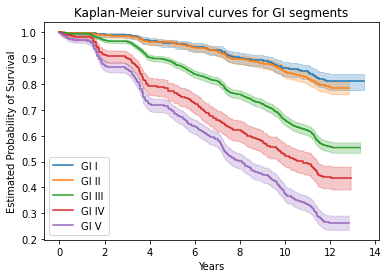

In [23]:
####GI segments

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
   
GI_I = data.init_GI==1      ## GI == 1 at wave 8
GI_II = data.init_GI==2      ## GI == 2 at wave 8
GI_III = data.init_GI==3      ## GI == 3 at wave 8
GI_IV = data.init_GI==4      ## GI == 4 at wave 8
GI_V = data.init_GI==5      ## GI == 5 at wave 8

## fit the model for GI I
kmf1.fit(data.time[GI_I], data.event[GI_I], label='GI I')
a1 = kmf1.plot()

## fit the model for GI II
kmf1.fit(data.time[GI_II], data.event[GI_II], label='GI II')
kmf1.plot(ax=a1)

## fit the model for GI III
kmf1.fit(data.time[GI_III], data.event[GI_III], label='GI III')
kmf1.plot(ax=a1)

## fit the model for GI IV
kmf1.fit(data.time[GI_IV], data.event[GI_IV], label='GI IV')
kmf1.plot(ax=a1)

## fit the model for GI V
kmf1.fit(data.time[GI_V], data.event[GI_V], label='GI V')

kmf1.plot(ax=a1,
    title='Kaplan-Meier survival curves for GI segments',
    xlabel='Years',
    ylabel='Estimated Probability of Survival'
);

kmf1_filepath = os.path.join(km_path, "KM_GI.png")
plt.savefig(kmf1_filepath)

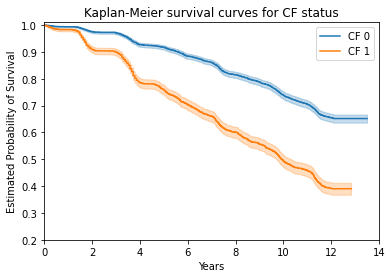

In [24]:
####Example 2

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

CF_0 = data.init_CF==0      ## CF == 0 at wave 8
CF_1 = data.init_CF==1      ## CF == 1 at wave 8

## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='CF 0')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='CF 1')
kmf1.plot(ax=a1,
    title='Kaplan-Meier survival curves for CF status',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

kmf1_filepath = os.path.join(km_path, "KM_CF.png")
plt.savefig(kmf1_filepath)

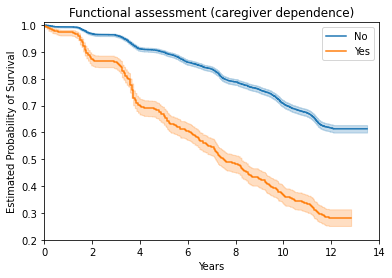

In [25]:
####Functional Assessment

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
  
CF_0 = data.fun_assess==0      ## CF == 0 at wave 8
CF_1 = data.fun_assess==1      ## CF == 1 at wave 8

## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Functional assessment (caregiver dependence)',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

kmf1_filepath = os.path.join(km_path, "KM_fun_assess.png")
plt.savefig(kmf1_filepath)

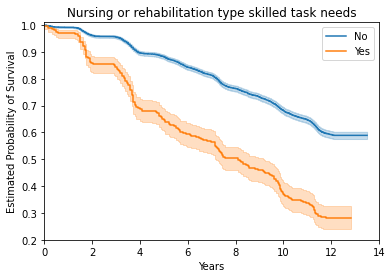

In [26]:
####Nursing type skilled task needs or rehabilitation type skilled task needs

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

CF_0 = data.nrs_rhab==0      ## CF == 0 at wave 8
CF_1 = data.nrs_rhab==1      ## CF == 1 at wave 8

## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Nursing or rehabilitation type skilled task needs',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

kmf1_filepath = os.path.join(km_path, "KM_nrs_rhab.png")
plt.savefig(kmf1_filepath)

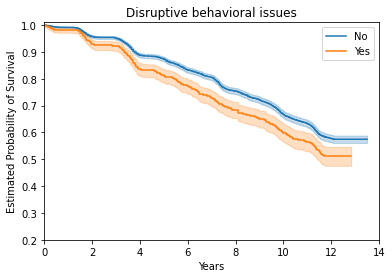

In [27]:
####Disruptive behavioral issues

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

CF_0 = data.disrupt==0      ## CF == 0 at wave 8
CF_1 = data.disrupt==1      ## CF == 1 at wave 8

## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Disruptive behavioral issues',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

kmf1_filepath = os.path.join(km_path, "KM_disrupt.png")
plt.savefig(kmf1_filepath)

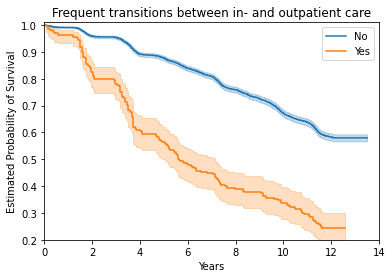

In [28]:
####Frequent transitions between inpatient and outpatient care

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

CF_0 = data.freq_trans==0      ## CF == 0 at wave 8
CF_1 = data.freq_trans==1      ## CF == 1 at wave 8

## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Frequent transitions between in- and outpatient care',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

kmf1_filepath = os.path.join(km_path, "KM_freq_trans.png")
plt.savefig(kmf1_filepath)

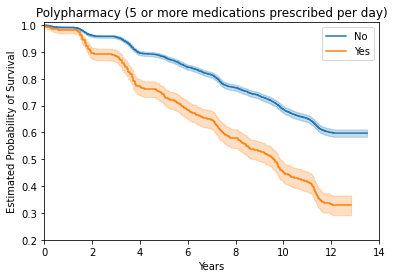

In [29]:
####Polypharmacy

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
 
CF_0 = data.polypharm==0      ## CF == 0 at wave 8
CF_1 = data.polypharm==1      ## CF == 1 at wave 8

## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
          title='Polypharmacy (5 or more medications prescribed per day)',
          xlabel='Years',
          ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

kmf1_filepath = os.path.join(km_path, "KM_polypharm.png")
plt.savefig(kmf1_filepath)

# 3. Cox proportional hazard models of mortality

## 3.1. Prepare data

In [30]:
#define data for cox regression
data_cox = pd.DataFrame(data) 

#Controlling: Age, age-squared, female
data_cox["age_squared"] = data_cox.age*data_cox.age

#data_cox["female2"] = -3
data_cox.loc[(data_cox.gender=="1.male"),'gender'] = 0
data_cox.loc[(data_cox.gender=="2.female"),'gender'] = 1
data_cox.rename(columns = {'gender':'female'}, inplace = True)

#Create dummy variables for GI I
data_cox["init_GI_I"] = 0
data_cox.loc[(data_cox.init_GI==1),'init_GI_I'] = 1
#Create dummy variables for GI II
data_cox["init_GI_II"] = 0
data_cox.loc[(data_cox.init_GI==2),'init_GI_II'] = 1
#Create dummy variables for GI III
data_cox["init_GI_III"] = 0
data_cox.loc[(data_cox.init_GI==3),'init_GI_III'] = 1
#Create dummy variables for GI IV
data_cox["init_GI_IV"] = 0
data_cox.loc[(data_cox.init_GI==4),'init_GI_IV'] = 1
#Create dummy variables for GI V
data_cox["init_GI_V"] = 0
data_cox.loc[(data_cox.init_GI==5),'init_GI_V'] = 1

#Create severe variables
data_cox["init_GI_severe"] = 0
data_cox.loc[(data_cox.init_GI==4),'init_GI_severe'] = 1
data_cox.loc[(data_cox.init_GI==5),'init_GI_severe'] = 1

data_cox = data_cox[['init_GI_severe', 'init_GI', 'init_CF', 
                     'init_GI_I', 'init_GI_II', 'init_GI_III', 
                     'init_GI_IV', 'init_GI_V', 'fun_assess', 
                     'nrs_rhab', 'disrupt', 'freq_trans', 
                     'polypharm', 'event', 'time', 'age', 
                     'age_squared', 'female']]

data_cox_GI_CF = data_cox[['init_GI_II', 'init_GI_III', 
                           'init_GI_IV', 'init_GI_V', 'init_CF', 
                           'event', 'time', 'age', 'age_squared', 
                           'female']]
data_cox_GI_all = data_cox[['init_GI_II', 'init_GI_III', 
                            'init_GI_IV', 'init_GI_V', 'event', 
                            'time', 'age', 'age_squared', 'female']]
data_cox_CF = data_cox[['init_CF', 'event', 'time', 'age', 
                        'age_squared', 'female']]

data_cox_GI_I = data_cox[['init_GI_I', 'event', 'time', 'age', 
                          'age_squared', 'female']]
data_cox_GI_II = data_cox[['init_GI_II', 'event', 'time', 'age', 
                           'age_squared', 'female']]
data_cox_GI_III = data_cox[['init_GI_III', 'event', 'time', 'age', 
                            'age_squared', 'female']]
data_cox_GI_IV = data_cox[['init_GI_IV', 'event', 'time', 'age', 
                           'age_squared', 'female']]
data_cox_GI_V = data_cox[['init_GI_V', 'event', 'time', 'age', 
                          'age_squared', 'female']]

data_cox_CF_all = data_cox[['fun_assess', 'nrs_rhab', 'disrupt', 
                            'freq_trans', 'polypharm', 'event', 
                            'time', 'age', 'age_squared', 'female']]
data_cox_CF_fun_assess = data_cox[['fun_assess', 'event', 'time', 
                                   'age', 'age_squared', 'female']]
data_cox_CF_nrs_rhab = data_cox[['nrs_rhab', 'event', 'time', 'age', 
                                 'age_squared', 'female']]
data_cox_CF_disrupt = data_cox[['disrupt', 'event', 'time', 'age', 
                                'age_squared', 'female']]
data_cox_CF_freq_trans = data_cox[['freq_trans', 'event', 'time', 
                                   'age', 'age_squared', 'female']]
data_cox_CF_polypharm = data_cox[['polypharm', 'event', 'time', 'age', 
                                  'age_squared', 'female']]


### 3.2. Model fitting

#### GI II, GI III, GI IV, GI V, CF

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20614.73
         time fit was run = 2023-03-20 21:26:39 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.17       0.85       0.11            -0.39             0.05                 0.68                 1.05
init_GI_III   0.49       1.63       0.10             0.30             0.68                 1.35                 1.96
init_GI_IV    0.93       2.54       0.11             0.72             1.15                 2.05                 3.15
init_GI_V     1.11       3.02       0.10             0.91             1.31                 2.48                 3.69
init_CF       0.41       1.51       0.04             0.33             0.50                 1.39                 1.65
age           0.07       1.07       0.03             0.02             0.12                 1.02                 1.13
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.37       0.69       0.04            -0.45            -0.29                 0.64                 0.75

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_II      0.00 -1.50   0.13       2.89
init_GI_III     0.00  5.03 <0.005      20.93
init_GI_IV      0.00  8.51 <0.005      55.62
init_GI_V       0.00 10.89 <0.005      89.28
init_CF         0.00  9.59 <0.005      69.95
age             0.00  2.57   0.01       6.62
age_squared     0.00  0.75   0.45       1.15
female          0.00 -9.37 <0.005      66.92
---
Concordance = 0.78
Partial AIC = 41245.47
log-likelihood ratio test = 2830.59 on 8 df
-log2(p) of ll-ratio test = inf

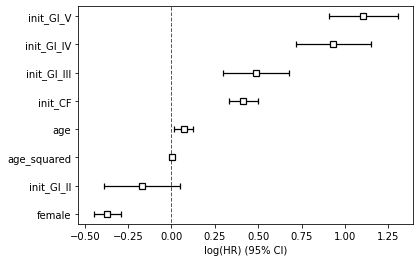

In [31]:
cphGI_CF = CoxPHFitter()
cphGI_CF.fit(data_cox_GI_CF, "time", event_col="event")
cphGI_CF.print_summary()
cphGI_CF.plot()

cph_filepath = os.path.join(cr_path, "CR_II_III_IV_V_CF.png")
plt.savefig(cph_filepath)

#### GI II, GI III, GI IV, GI V

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20660.40
         time fit was run = 2023-03-20 21:26:43 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.17       0.85       0.11            -0.38             0.05                 0.68                 1.06
init_GI_III   0.56       1.75       0.10             0.37             0.75                 1.45                 2.11
init_GI_IV    1.06       2.88       0.11             0.84             1.27                 2.33                 3.56
init_GI_V     1.33       3.77       0.10             1.13             1.52                 3.11                 4.58
age           0.06       1.06       0.03             0.00             0.11                 1.00                 1.11
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.34       0.71       0.04            -0.42            -0.26                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_II      0.00 -1.48   0.14       2.85
init_GI_III     0.00  5.80 <0.005      27.15
init_GI_IV      0.00  9.73 <0.005      71.88
init_GI_V       0.00 13.43 <0.005     134.25
age             0.00  2.07   0.04       4.71
age_squared     0.00  1.28   0.20       2.32
female          0.00 -8.64 <0.005      57.35
---
Concordance = 0.77
Partial AIC = 41334.80
log-likelihood ratio test = 2739.26 on 7 df
-log2(p) of ll-ratio test = inf

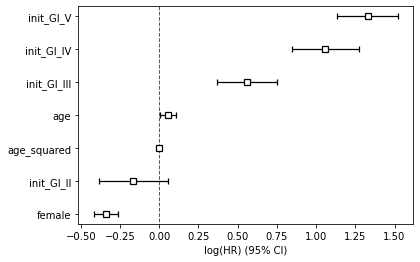

In [32]:
cphGI = CoxPHFitter()
cphGI.fit(data_cox_GI_all, "time", event_col="event")
cphGI.print_summary()
cphGI.plot()

cph_filepath = os.path.join(cr_path, "CR_II_III_IV_V.png")
plt.savefig(cph_filepath)

#### CF

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20801.99
         time fit was run = 2023-03-20 21:26:45 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_CF       0.72       2.05       0.04             0.64             0.80                 1.90                 2.22
age           0.07       1.07       0.03             0.02             0.12                 1.02                 1.13
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.39       0.67       0.04            -0.47            -0.32                 0.62                 0.73

              cmp to     z      p   -log2(p)
covariate                                   
init_CF         0.00 18.02 <0.005     238.85
age             0.00  2.68   0.01       7.07
age_squared     0.00  0.88   0.38       1.41
female          0.00 -9.96 <0.005      75.22
---
Concordance = 0.76
Partial AIC = 41611.98
log-likelihood ratio test = 2456.08 on 4 df
-log2(p) of ll-ratio test = inf

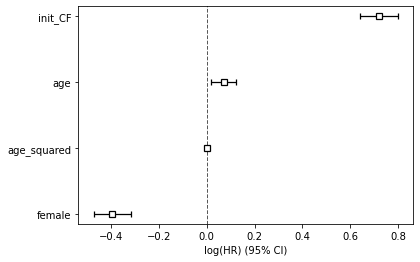

In [33]:
cphCF = CoxPHFitter()
cphCF.fit(data_cox_CF, "time", event_col="event")
cphCF.print_summary()
cphCF.plot()

cph_filepath = os.path.join(cr_path, "CR_CF.png")
plt.savefig(cph_filepath)

#### GI I

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20929.76
         time fit was run = 2023-03-20 21:26:47 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_I    -0.66       0.52       0.09            -0.84            -0.47                 0.43                 0.62
age           0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.36       0.70       0.04            -0.44            -0.28                 0.65                 0.75

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_I       0.00 -7.01 <0.005      38.58
age             0.00  0.87   0.38       1.39
age_squared     0.00  2.76   0.01       7.42
female          0.00 -9.11 <0.005      63.33
---
Concordance = 0.74
Partial AIC = 41867.52
log-likelihood ratio test = 2200.54 on 4 df
-log2(p) of ll-ratio test = inf

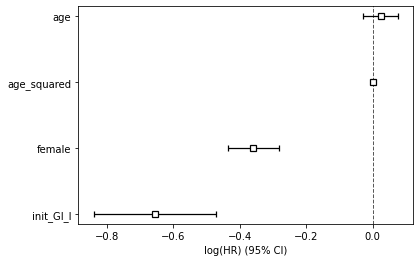

In [34]:
cphGI_I = CoxPHFitter()
cphGI_I.fit(data_cox_GI_I, "time", event_col="event")
cphGI_I.print_summary()
cphGI_I.plot()

cph_filepath = os.path.join(cr_path, "CR_I.png")
plt.savefig(cph_filepath)

#### GI II

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20843.77
         time fit was run = 2023-03-20 21:26:49 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.92       0.40       0.07            -1.05            -0.78                 0.35                 0.46
age           0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.31       0.73       0.04            -0.39            -0.24                 0.68                 0.79

              cmp to      z      p   -log2(p)
covariate                                    
init_GI_II      0.00 -13.47 <0.005     135.02
age             0.00   2.16   0.03       5.03
age_squared     0.00   1.46   0.14       2.80
female          0.00  -7.96 <0.005      49.08
---
Concordance = 0.75
Partial AIC = 41695.53
log-likelihood ratio test = 2372.52 on 4 df
-log2(p) of ll-ratio test = inf

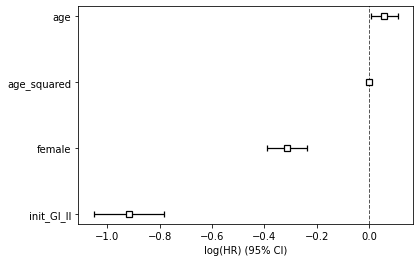

In [35]:
cphGI_II = CoxPHFitter()
cphGI_II.fit(data_cox_GI_II, "time", event_col="event")
cphGI_II.print_summary()
cphGI_II.plot()

cph_filepath = os.path.join(cr_path, "CR_II.png")
plt.savefig(cph_filepath)

#### GI III

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20952.34
         time fit was run = 2023-03-20 21:26:51 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_III  -0.15       0.86       0.04            -0.23            -0.07                 0.80                 0.93
age           0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.35       0.71       0.04            -0.43            -0.27                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_III     0.00 -3.80 <0.005      12.73
age             0.00  2.15   0.03       5.00
age_squared     0.00  1.55   0.12       3.05
female          0.00 -8.84 <0.005      59.89
---
Concordance = 0.74
Partial AIC = 41912.68
log-likelihood ratio test = 2155.37 on 4 df
-log2(p) of ll-ratio test = inf

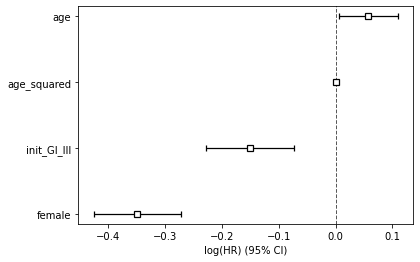

In [36]:
cphGI_III = CoxPHFitter()
cphGI_III.fit(data_cox_GI_III, "time", event_col="event")
cphGI_III.print_summary()
cphGI_III.plot()

cph_filepath = os.path.join(cr_path, "CR_III.png")
plt.savefig(cph_filepath)

#### GI IV

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20937.98
         time fit was run = 2023-03-20 21:26:53 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_IV    0.44       1.55       0.06             0.31             0.56                 1.37                 1.75
age           0.07       1.08       0.03             0.02             0.13                 1.02                 1.13
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.34       0.71       0.04            -0.42            -0.27                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_IV      0.00  6.93 <0.005      37.80
age             0.00  2.74   0.01       7.33
age_squared     0.00  0.92   0.36       1.49
female          0.00 -8.69 <0.005      57.95
---
Concordance = 0.74
Partial AIC = 41883.95
log-likelihood ratio test = 2184.10 on 4 df
-log2(p) of ll-ratio test = inf

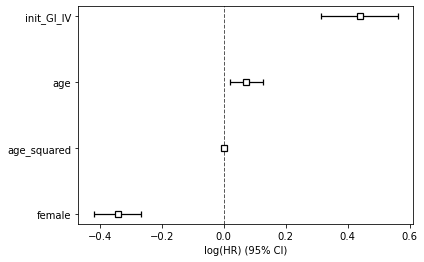

In [37]:
cphGI_IV = CoxPHFitter()
cphGI_IV.fit(data_cox_GI_IV, "time", event_col="event")
cphGI_IV.print_summary()
cphGI_IV.plot()

cph_filepath = os.path.join(cr_path, "CR_IV.png")
plt.savefig(cph_filepath)

#### GI V

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20779.23
         time fit was run = 2023-03-20 21:26:55 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_V     0.87       2.39       0.04             0.79             0.96                 2.20                 2.60
age           0.04       1.04       0.03            -0.01             0.09                 0.99                 1.10
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.36       0.70       0.04            -0.43            -0.28                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_V       0.00 20.21 <0.005     299.35
age             0.00  1.46   0.14       2.79
age_squared     0.00  2.07   0.04       4.68
female          0.00 -9.01 <0.005      62.10
---
Concordance = 0.76
Partial AIC = 41566.46
log-likelihood ratio test = 2501.60 on 4 df
-log2(p) of ll-ratio test = inf

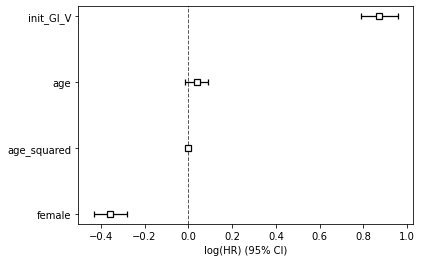

In [38]:
cphGI_V = CoxPHFitter()
cphGI_V.fit(data_cox_GI_V, "time", event_col="event")
cphGI_V.print_summary()
cphGI_V.plot()

cph_filepath = os.path.join(cr_path, "CR_V.png")
plt.savefig(cph_filepath)

#### Functional assessment, nursing and rehabilitation type skills needs, disruptive behavioral issues, frequent transition between inpatient and outpatient care, polypharmacy

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20748.92
         time fit was run = 2023-03-20 21:26:57 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
fun_assess    0.64       1.89       0.05             0.54             0.73                 1.71                 2.08
nrs_rhab      0.16       1.17       0.06             0.03             0.28                 1.03                 1.33
disrupt       0.35       1.42       0.06             0.24             0.46                 1.27                 1.59
freq_trans    0.34       1.40       0.08             0.18             0.49                 1.20                 1.64
polypharm     0.43       1.53       0.05             0.32             0.53                 1.38                 1.71
age           0.08       1.08       0.03             0.02             0.13                 1.02                 1.14
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.41       0.66       0.04            -0.49            -0.33                 0.61                 0.72

              cmp to      z      p   -log2(p)
covariate                                    
fun_assess      0.00  12.67 <0.005     119.83
nrs_rhab        0.00   2.44   0.01       6.08
disrupt         0.00   6.22 <0.005      30.92
freq_trans      0.00   4.26 <0.005      15.59
polypharm       0.00   7.77 <0.005      46.87
age             0.00   2.85 <0.005       7.84
age_squared     0.00   0.62   0.54       0.90
female          0.00 -10.29 <0.005      80.08
---
Concordance = 0.76
Partial AIC = 41513.84
log-likelihood ratio test = 2562.22 on 8 df
-log2(p) of ll-ratio test = inf

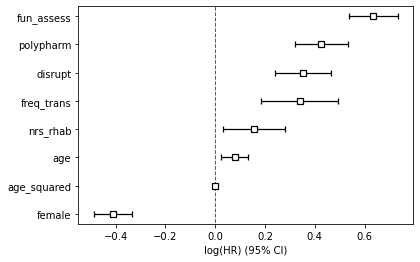

In [39]:
cphCF_all = CoxPHFitter()
cphCF_all.fit(data_cox_CF_all, "time", event_col="event")
cphCF_all.print_summary()
cphCF_all.plot()

cph_filepath = os.path.join(cr_path, "CR_CFs.png")
plt.savefig(cph_filepath)

#### Functional assessment

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20828.91
         time fit was run = 2023-03-20 21:26:59 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
fun_assess    0.82       2.26       0.05             0.72             0.91                 2.06                 2.48
age           0.09       1.09       0.03             0.04             0.14                 1.04                 1.15
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.38       0.69       0.04            -0.45            -0.30                 0.64                 0.74

              cmp to     z      p   -log2(p)
covariate                                   
fun_assess      0.00 17.27 <0.005     219.60
age             0.00  3.26 <0.005       9.81
age_squared     0.00  0.17   0.86       0.21
female          0.00 -9.49 <0.005      68.61
---
Concordance = 0.75
Partial AIC = 41665.82
log-likelihood ratio test = 2402.24 on 4 df
-log2(p) of ll-ratio test = inf

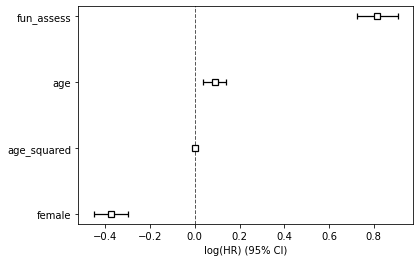

In [40]:
cphCF_fun_assess = CoxPHFitter()
cphCF_fun_assess.fit(data_cox_CF_fun_assess, "time", event_col="event")
cphCF_fun_assess.print_summary()
cphCF_fun_assess.plot()

cph_filepath = os.path.join(cr_path, "CR_fun_assess.png")
plt.savefig(cph_filepath)

#### Nursing and rehabilitation type skills needs

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20930.55
         time fit was run = 2023-03-20 21:27:01 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
nrs_rhab      0.49       1.63       0.06             0.37             0.61                 1.45                 1.84
age           0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.35       0.70       0.04            -0.43            -0.27                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
nrs_rhab        0.00  8.03 <0.005      49.90
age             0.00  2.21   0.03       5.21
age_squared     0.00  1.43   0.15       2.72
female          0.00 -8.89 <0.005      60.55
---
Concordance = 0.74
Partial AIC = 41869.11
log-likelihood ratio test = 2198.95 on 4 df
-log2(p) of ll-ratio test = inf

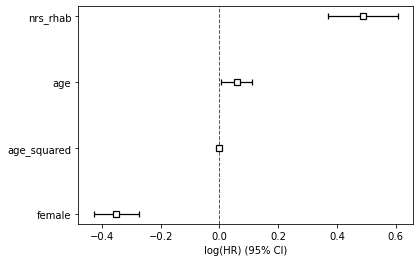

In [41]:
cphCF_nrs_rhab = CoxPHFitter()
cphCF_nrs_rhab.fit(data_cox_CF_nrs_rhab, "time", event_col="event")
cphCF_nrs_rhab.print_summary()
cphCF_nrs_rhab.plot()

cph_filepath = os.path.join(cr_path, "CR_nrs_rhab.png")
plt.savefig(cph_filepath)

#### Disruptive behavioral issues

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20913.00
         time fit was run = 2023-03-20 21:27:03 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
disrupt       0.56       1.76       0.05             0.46             0.67                 1.58                 1.96
age           0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.39       0.68       0.04            -0.47            -0.31                 0.62                 0.73

              cmp to     z      p   -log2(p)
covariate                                   
disrupt         0.00 10.27 <0.005      79.76
age             0.00  2.16   0.03       5.02
age_squared     0.00  1.60   0.11       3.19
female          0.00 -9.85 <0.005      73.68
---
Concordance = 0.74
Partial AIC = 41834.00
log-likelihood ratio test = 2234.05 on 4 df
-log2(p) of ll-ratio test = inf

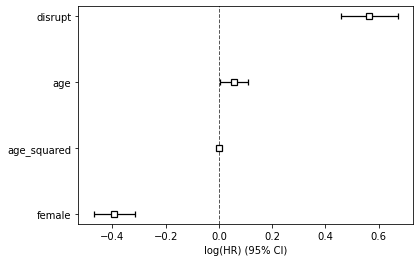

In [42]:
cphCF_disrupt = CoxPHFitter()
cphCF_disrupt.fit(data_cox_CF_disrupt, "time", event_col="event")
cphCF_disrupt.print_summary()
cphCF_disrupt.plot()

cph_filepath = os.path.join(cr_path, "CR_disrupt.png")
plt.savefig(cph_filepath)

#### Frequent transition between inpatient and outpatient care

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20929.42
         time fit was run = 2023-03-20 21:27:05 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
freq_trans    0.70       2.01       0.08             0.53             0.86                 1.70                 2.37
age           0.05       1.05       0.03            -0.01             0.10                 0.99                 1.10
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.35       0.71       0.04            -0.42            -0.27                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
freq_trans      0.00  8.24 <0.005      52.42
age             0.00  1.76   0.08       3.67
age_squared     0.00  1.93   0.05       4.21
female          0.00 -8.79 <0.005      59.26
---
Concordance = 0.74
Partial AIC = 41866.84
log-likelihood ratio test = 2201.22 on 4 df
-log2(p) of ll-ratio test = inf

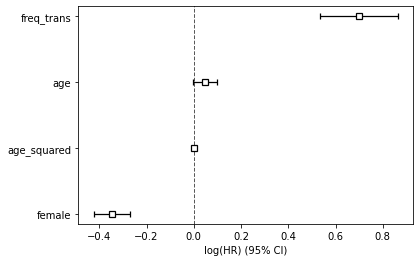

In [43]:
cphCF_freq_trans = CoxPHFitter()
cphCF_freq_trans.fit(data_cox_CF_freq_trans, "time", event_col="event")
cphCF_freq_trans.print_summary()
cphCF_freq_trans.plot()

cph_filepath = os.path.join(cr_path, "CR_freq_trans.png")
plt.savefig(cph_filepath)

#### Polypharmacy

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20873.39
         time fit was run = 2023-03-20 21:27:07 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
polypharm     0.72       2.06       0.05             0.62             0.82                 1.86                 2.27
age           0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.35       0.70       0.04            -0.43            -0.28                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
polypharm       0.00 14.18 <0.005     149.15
age             0.00  0.88   0.38       1.40
age_squared     0.00  2.82 <0.005       7.69
female          0.00 -8.98 <0.005      61.66
---
Concordance = 0.75
Partial AIC = 41754.78
log-likelihood ratio test = 2313.27 on 4 df
-log2(p) of ll-ratio test = inf

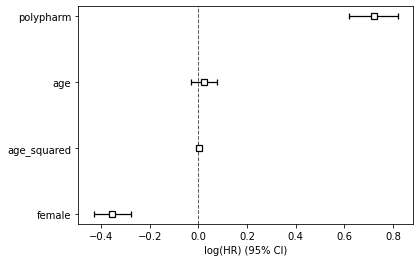

In [44]:
cphCF_polypharm = CoxPHFitter()
cphCF_polypharm.fit(data_cox_CF_polypharm, "time", event_col="event")
cphCF_polypharm.print_summary()
cphCF_polypharm.plot()

cph_filepath = os.path.join(cr_path, "CR_polypharm.png")
plt.savefig(cph_filepath)